Epoch [1/50], d_loss: 1.2743, g_loss: 0.8421
Epoch [2/50], d_loss: 1.2510, g_loss: 0.8644
Epoch [3/50], d_loss: 0.9303, g_loss: 0.8548
Epoch [4/50], d_loss: 0.9429, g_loss: 0.8386
Epoch [5/50], d_loss: 0.9487, g_loss: 0.9380
Epoch [6/50], d_loss: 0.6631, g_loss: 1.0548
Epoch [7/50], d_loss: 1.0378, g_loss: 1.1180
Epoch [8/50], d_loss: 0.7384, g_loss: 1.5925
Epoch [9/50], d_loss: 0.3862, g_loss: 1.4817
Epoch [10/50], d_loss: 0.3153, g_loss: 1.6904
Epoch [11/50], d_loss: 0.6189, g_loss: 1.1306
Epoch [12/50], d_loss: 0.5510, g_loss: 1.3586
Epoch [13/50], d_loss: 0.7665, g_loss: 1.6303
Epoch [14/50], d_loss: 0.6143, g_loss: 1.8024
Epoch [15/50], d_loss: 0.2846, g_loss: 1.9181
Epoch [16/50], d_loss: 0.4902, g_loss: 1.8142
Epoch [17/50], d_loss: 0.1919, g_loss: 2.2489
Epoch [18/50], d_loss: 0.1569, g_loss: 2.0330
Epoch [19/50], d_loss: 0.3878, g_loss: 1.9467
Epoch [20/50], d_loss: 0.1684, g_loss: 1.9926
Epoch [21/50], d_loss: 0.5260, g_loss: 2.1274
Epoch [22/50], d_loss: 0.3528, g_loss: 2.28

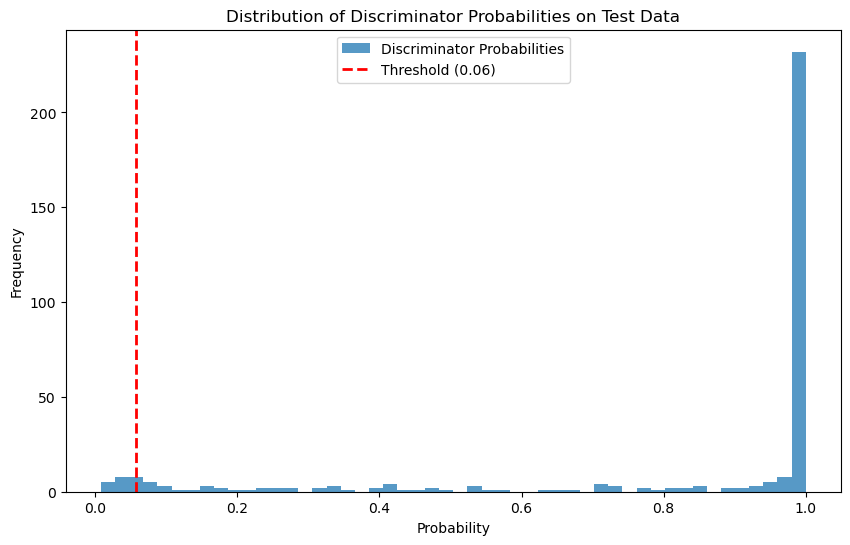

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Đọc dữ liệu và chuẩn hóa
data = pd.read_csv('../../data/Chiller.csv')
features = data.drop(columns=['Time'], errors='ignore')  # Bỏ cột 'Time' nếu có

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 2. Chia dữ liệu: sử dụng 80% cho huấn luyện và 20% cho kiểm tra
train_size = int(0.8 * len(scaled_features))
X_train = scaled_features[:train_size]
X_test = scaled_features[train_size:]

# Chuyển đổi thành tensor cho PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 3. Định nghĩa Generator và Discriminator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 4. Khởi tạo mô hình và optimizer
latent_dim = 10  # Chiều không gian ẩn
input_dim = X_train.shape[1]  # Số lượng đặc trưng trong dữ liệu

generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# 5. Huấn luyện GAN với dữ liệu bình thường
epochs = 50
batch_size = 32
train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for real_data in train_loader:
        # Huấn luyện Discriminator
        optimizer_d.zero_grad()
        real_labels = torch.ones((real_data.size(0), 1))  # Kích thước (real_data.size(0), 1)
        fake_labels = torch.zeros((real_data.size(0), 1))

        noise = torch.randn(real_data.size(0), latent_dim)
        fake_data = generator(noise)

        real_loss = nn.BCELoss()(discriminator(real_data), real_labels)
        fake_loss = nn.BCELoss()(discriminator(fake_data.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Huấn luyện Generator
        optimizer_g.zero_grad()
        generated_data = generator(noise)
        g_loss = nn.BCELoss()(discriminator(generated_data), real_labels)
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch + 1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

# 6. Dự đoán trên tập kiểm tra
discriminator.eval()
with torch.no_grad():
    test_probs = discriminator(X_test_tensor).numpy().flatten()

# 7. Thiết lập ngưỡng và đánh dấu điểm bất thường
threshold = np.percentile(test_probs, 5)  # Ngưỡng từ phân vị 5%
anomalies = (test_probs < threshold).astype(int)  # Đánh dấu bất thường nếu xác suất < ngưỡng

# 8. Đánh giá số lượng điểm bất thường và vẽ biểu đồ phân phối xác suất
print("Số lượng điểm bất thường được phát hiện:", anomalies.sum())

plt.figure(figsize=(10, 6))
plt.hist(test_probs, bins=50, alpha=0.75, label='Discriminator Probabilities')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Discriminator Probabilities on Test Data')
plt.legend()
plt.show()
